## 0.회귀 분석의 종류

### Simple Linear Regression
- 단순 선형 회귀
- $y = \beta_{0} + \beta_{1} x + \epsilon$
- 하나의 X 값을 가지고 Y를 예측하는 것

### Multiple Linear Regression
- 다중 회귀
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + ...+ \epsilon$
- 여러 개의 X 값을 가지고 Y를 예측하는 것

### Polynomial Regression
- 다항 회귀
- 비선형 데이터 집합을 모델링 할 때 사용
- 곡선의 다항식 선을 사용함
- 과대적합이 나타나기 쉬움
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{1}^{2} + \beta_{4} x_{2}^{2} ...+ \epsilon$
- X를 다항식으로 변경하여 모델링의 데이터로 사용함

### Ridge, Lasso Regression
- 독립변수들 간에 높은 상관 관계가 있는 경우 규제화 (regularization)를 적용해 모델의 복잡도를 줄임
- Ridge : 계수값을 0 에 가깝게 만들지만 0 이 되지 않음
- Lasso : 계수 값을 0 이 되게 함으로써 그에 해당하는 특성을 제외

## 1.데이터 만들기 

### 1-1.함수 만들기

In [ ]:
# X : 키, 몸무게 
# Y : BMI 예측

In [1]:
import pandas as pd
import numpy as np

In [2]:
# https://rfriend.tistory.com/284
# https://rfriend.tistory.com/352
# https://namu.wiki/w/%ED%82%A4(%EC%8B%A0%EC%B2%B4)
# https://123dok.co/document/eqodvrmz-%EC%A7%80%EC%97%AD%EC%A0%81-%EA%B1%B4%EA%B0%95%EB%B6%88%ED%8F%89%EB%93%B1%EA%B3%BC-%EA%B0%9C%EC%9D%B8-%EB%B0%8F-%EC%A7%80%EC%97%AD%EC%88%98%EC%A4%80%EC%9D%98-%EA%B1%B4%EA%B0%95%EA%B2%B0%EC%A0%95%EC%9A%94%EC%9D%B8.html

In [43]:
# bmi = 몸무게(kg) ÷ (신장(m) × 신장(m))
# 한국 표준 데이터 생성
# seedno : 랜덤 수 발생 관련
# size : sample의 개수
# startno : ID의 시작 번호
# outlier : 이상치 비율, 0.01 => 100개 정상데이터 1개 이상치
def make_sample(seedno, size, startno=0, outlier=0):
    np.random.seed(seedno)
    
    sizeh = size // 2
    outlier_len = int(size * outlier)
    
    hm = np.random.normal(loc=175, scale=5.3, size=(sizeh + 1 if size % 2 else sizeh)).round(1)
    hw = np.random.normal(loc=162, scale=5.2, size=sizeh).round(1)
    h = np.concatenate([hm, hw]) / 100
    bmi = np.random.normal(loc=23, scale=4, size=len(h))
    w = (h * h * bmi).round(1)
    bmi = (w / h ** 2).round(2)
    h *= 100
    
    data = np.column_stack([h, w, bmi])
    
    if outlier_len != 0:
        data_outlier = make_outlier(seedno, outlier_len)
        print(data_outlier, data_outlier.shape, sep='\n')
        data = np.concatenate([data, data_outlier])
    
    data = pd.DataFrame(data, columns=['height', 'weight', 'BMI']).sample(frac=1)
    data.insert(loc=0, column='ID', value=np.arange(startno, startno + len(data), dtype='int'))
    
    return data

In [44]:
# bmi = #몸무게(kg) ÷ (신장(m) × 신장(m))
# 키, 몸무게가 매우 작거나 큰 데이터 생성
# seedno : 랜덤 수 발생 관련
# size : sample의 개수
def make_outlier(seedno, size):
    np.random.seed(seedno)
    
    sizeh = size // 2
    
    hlow = np.random.normal(loc=120, scale=5.3, size=(sizeh + 1 if size % 2 else sizeh)).round(1)
    hhigh = np.random.normal(loc=220, scale=5.2, size=sizeh).round(1)
    h = np.concatenate([hlow, hhigh])
    h /= 100
    
    bmi = np.random.normal(loc=23, scale=10, size=len(h))
    w = (h * h * bmi).round(1)
    bmi = (w / h ** 2).round(2)
    h *= 100

    return np.column_stack([h, w, bmi])

In [45]:
# make_sample 사용연습
temp = make_sample(1234, 100, outlier=0.05)
temp.shape

[[122.5   47.8   31.85]
 [113.7   40.8   31.56]
 [127.6   27.1   16.64]
 [218.4  110.5   23.17]
 [216.3    2.7    0.58]]
(5, 3)


(105, 4)

### 1-2.train, test 데이터

In [46]:
# [1] train, test 데이터 생성 및 파일로 저장하기
train = make_sample(seedno=1234, size=100)
test = make_sample(seedno=1, size=100, startno=len(train))

Xfeatures = ['ID', 'height', 'weight']
Yfeatures = ['ID', 'BMI']

Xtrain = train[Xfeatures]
Ytrain = train[Yfeatures]

Xtest = test[Xfeatures]
Ytest = test[Yfeatures]

Xtrain.to_csv('./x_train.csv', index=False)
Ytrain.to_csv('./y_train.csv', index=False)
Xtest.to_csv('./x_test.csv', index=False)
Ytest.to_csv('./y_test.csv', index=False)

In [50]:
# [2] 각 데이터를 파일에서 읽어오기
# X_use, X_submission, Y, Y_hidden 이름 사용
X_use = pd.read_csv('./x_train.csv')
Y = pd.read_csv('./y_train.csv')
X_submission = pd.read_csv('./x_test.csv')
Y_hidden = pd.read_csv('./y_test.csv')

print(X_use.shape, Y.shape, X_submission.shape)
print(X_use.head(2))
print(Y.head(2))

(100, 3) (100, 2) (100, 3)
   ID  height  weight
0   0   163.1    71.3
1   1   175.1    85.5
   ID    BMI
0   0  26.80
1   1  27.89


In [55]:
# X_use, Y를 합쳐서 dfXY 생성
dfXY = pd.concat([X_use, Y['BMI']], axis=1)
dfXY.head()

,ID,height,weight,BMI
0,0,163.1,71.3,26.80
1,1,175.1,85.5,27.89
2,2,174.0,78.0,25.76
3,3,171.2,73.1,24.94
4,4,160.2,57.4,22.37


In [56]:
# dfXY의 상관 관계 확인
dfXY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      100 non-null    int64  
 1   height  100 non-null    float64
 2   weight  100 non-null    float64
 3   BMI     100 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.2 KB


In [57]:
dfXY.corr()

,ID,height,weight,BMI
ID,1.000000,0.140693,-0.022971,-0.108252
height,0.140693,1.000000,0.604015,0.178859
weight,-0.022971,0.604015,1.000000,0.887726
BMI,-0.108252,0.178859,0.887726,1.000000


## 2.모델링, 성능평가

### 2-1.모델링 함수

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [72]:
# [1] 데이터를 분리하고, 학습 한 뒤, R2_score를 구해 출력
def Model_Train(model, XF, YF):
    # 7:3 분리, random_state=321  (주의: stratify사용 안함 -> 분류 모델에서만 사용)
    # Xscaled = MinMaxScaler().fit_transform(XF)
    xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, test_size=0.3, random_state=321)

    model.fit(xtrain, ytrain)
    A = model.score(xtrain, ytrain)
    B = model.score(xtest, ytest)
    print(f'Train R2 Score:{A:.4f}. Test R2 Score: {B:.4f}')
    
    return model

### 2-2. Multiple Linear Regression
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + ...+ \epsilon$
- 오차(잔차)가 가장 적게 발생하는 계수, 절편 찾기

In [73]:
# [2] outlier가 포함되지 않은 경우, LinearRegression 모델 사용  
Xnormal = X_use[['height', 'weight']]
Ynormal = Y['BMI']
model = LinearRegression()

model = Model_Train(model, Xnormal, Ynormal)

Train R2 Score:0.9931. Test R2 Score: 0.9625


In [77]:
# [3] 계수들과 절편 출력해 보기
model.coef_, model.intercept_, model.feature_names_in_

(array([-0.28008565,  0.34383133]),
 47.629018625993695,
 array(['height', 'weight'], dtype=object))

### 2-3.이상치

In [108]:
# [4] 이상치를 포함한 데이터 생성 (outlier=0.07 사용)
Toutlier = make_sample(1234, 100, outlier=0.07)
Xoutlier = Toutlier[['height', 'weight']]
Youtlier = Toutlier['BMI']

model2 = Model_Train(LinearRegression(), Xoutlier, Youtlier)

[[122.5   25.    16.66]
 [113.7   29.9   23.13]
 [127.6    0.9    0.55]
 [118.3   48.3   34.51]
 [216.3  154.    32.92]
 [224.6  164.1   32.53]
 [224.5   14.     2.78]]
(7, 3)
Train R2 Score:0.9296. Test R2 Score: 0.4557


In [109]:
# [5] 이상치가 포함된 경우, LinearRegression 모델 사용
model2.coef_, model2.intercept_, model2.feature_names_in_

(array([-0.26848092,  0.38145941]),
 43.11910543870737,
 array(['height', 'weight'], dtype=object))

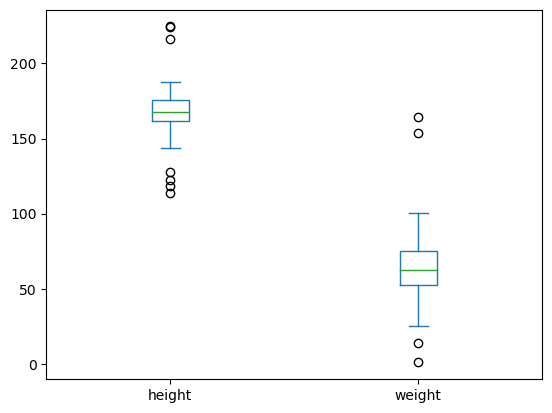

In [110]:
# [6] 그래프 사용하여 이상치 확인
import matplotlib.pyplot as plt
import seaborn as sns

Xoutlier.plot(kind='box')

plt.show()

In [111]:
# [7] 각 feature별 Q1, Q3 확인
Xoutlier.quantile([0.25, 0.75])

,height,weight
0.25,162.00,52.75
0.75,175.85,75.00


In [115]:
# [8] height에 대한 outlier 확인
Q1, Q3 = Xoutlier['height'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_h = round(Q1 - 1.5 * IQR, 3)
upper_h = round(Q3 + 1.5 * IQR, 3)
print(lower_h, upper_h)

141.225 196.625


In [116]:
# [9] weight에 대한 outlier 확인
Q1, Q3 = Xoutlier['weight'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_w = round(Q1 - 1.5 * IQR, 3)
upper_w = round(Q3 + 1.5 * IQR, 3)
print(lower_w, upper_w)

19.375 108.375


In [132]:
# [10] height에 대한 outlier 제거 및 학습
height = Xoutlier['height']
outlier_h = Xoutlier.loc[(height < lower_h) | (height > upper_h), :]
Xoutlier_rh = Xoutlier.drop(index=outlier_h.index)
Youtlier_rh = Youtlier.drop(index=outlier_h.index)

In [133]:
model3 = Model_Train(LinearRegression(), Xoutlier_rh, Youtlier_rh)

Train R2 Score:0.9868. Test R2 Score: 0.9935


In [134]:
# [11] weight에 대한 outlier 제거 및 학습
weight = Xoutlier['weight']
outlier_w = Xoutlier.loc[(weight < lower_w) | (weight > upper_w), :]
Xoutlier_rw = Xoutlier.drop(index=outlier_w.index)
Youtlier_rw = Youtlier.drop(index=outlier_w.index)

In [135]:
model4 = Model_Train(LinearRegression(), Xoutlier_rw, Youtlier_rw)

Train R2 Score:0.9731. Test R2 Score: 0.9217


### 2-4.Polynomial Regression
- 다항 회귀
- 비선형 데이터 집합을 모델링 할 때 사용
- 곡선의 다항식 선을 사용함
- 과대적합이 나타나기 쉬움
- $y = \beta_{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{1}^{2} + \beta_{4} x_{2}^{2} ...+ \epsilon$
- X를 다항식으로 변경하여 모델링의 데이터로 사용함

In [ ]:
# sklearn.preprocessing.PolynomialFeatures(degree=2, *, 
#               interaction_only=False, include_bias=True, order='C')

In [ ]:
# [12] PolynomialFeatures 사용하여 2차항이 포함되도록 
# Xnormal을 변환 함 (PolynomialFeatures에 poly2, 변환 결과에 Xpoly2 이름 부여)


In [ ]:
# [13] Xpoly2의 shape 확인


In [ ]:
# [14] poly2의 feature_names 확인


In [ ]:
# [15] Xpoly2의 상관계수 확인 


In [ ]:
# [16] PolynomialFeatures 사용하여 3차항이 포함되도록
# Xnormal을 변환 함 (PolynomialFeatures에 poly3, 변환 결과에 Xpoly3 이름 부여)


In [ ]:
# [17] Xpoly3의 shape 확인


In [ ]:
# [18] poly3의 shape 확인


### 2-5.Ridge Regression
- sklearn.linear_model.Ridge(alpha=1.0, *, fit_intercept=True, normalize='deprecated', copy_X=True, max_iter=None, tol=0.001, solver='auto', positive=False, random_state=None)
- coef(회귀계수)가 작아지지만 0이 되지는 않음

In [ ]:
# alpha=0 : 규제를 주지 않음
# alpha 값이 크다는 것은 규제를 크게 주겠다는 것을 의미 => coef_ 값들이 작아짐

In [ ]:
# [19] PolynomialFeatures degree=3과 Ridge를 사용한 모델링


In [ ]:
# [20] ridge_coef 출력하여 회귀계수 확인


### 2-6.Lasso Regression
- sklearn.linear_model.Lasso(alpha=1.0, *, fit_intercept=True, normalize='deprecated', precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
- 규제강도가 커지면 회귀계수가 작아지고 0도 될 수 있다

In [ ]:
# [21] degree=3과 Lasso를 사용한 모델링


In [ ]:
# [22] lasso_coef 출력하여 회귀계수 확인


In [ ]:
# Ridge, Lasso는 overfitting 되는 데이터에 주로 사용하여 overfitting을 해결하는 용도로 사용한다

### 2-7.DecisionTree 
- sklearn.tree.DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0

In [ ]:
# [22] Xnormal, Ynormal 데이터에 DecisionTreeRegressor 사용


In [ ]:
# train  test   
# 1.0000 0.7371  => overfitting, 과대적합
# 과대적합 해결방법 => Ridge, Lasso, 앙상블
#                      데이터의 크기를 늘리는 것, 함수의 parameter에 값을 변경

In [ ]:
# [23] 데이터의 개수를 2000개로 늘려 DecisionTreeRegressor 사용 


### 2-8.앙상블

- sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [ ]:
# [24] Xnormal, Ynormal 데이터에 RandomForestRegressor 사용


In [ ]:
# [25] Xnormal을 2차식으로 만든 후 RandomForestRegressor 사용


In [ ]:
# [26] 데이터의 개수를 2000개로 늘려 RandomForestRegressor 사용


- XBGRegressor : max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective="reg:linear", booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type="gain", **kwargs) 

In [ ]:
# [27] Xnormal, Ynormal 데이터에 XGBRegressor 사용


In [ ]:
# [28] 데이터의 개수를 2000개로 늘려 XGBRegressor 사용


## 3.회귀 모델 성능평가

- $R^2$ score
  - model.score(X, y)
  - sklearn.metrics.r2_score(y_true, y_pred)
  - 분산 기반으로 예측 성능을 평가
  - 예측값 분산 / 실제값 분산
- MAE(Mean Absolute Error)
   - sklearn.metrics.mean_absolute_error(y_true, y_pred)
   - 실제 값과 예측 값의 차이를 절댓값으로 변환해 평균한 것
- MSE(Mean Squared Error)
   - sklearn.metrics.mean_squared_error(y_true, y_pred)  
   - 실제 값과 예측 값의 차이를 제곱해 평균한 것
- RMSE(Root Mean Squared Error)
   - sklearn API에 없음
   - MSE에 np.sqrt() 또는 ** 0.5를 사용함
   - MSE 값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있어 MSE에 루트를 씌운 것
- MSLE(Mean Squared Log Error)
   - sklearn.metrics.mean_squared_log_error(y_true, y_pred)
   - MSE에 로그를 적용해준 지표
- RMSLE(Root Mean Square Logarithmic Error) 
   - RMSE에 로그를 적용해준 지표
   - 이상치가 있더라도 변동폭이 크지 않음(이상치에 강건함)
   - 실제값보다 예측값이 작을 때 더 큰 패널티 부여
   - 작게 예측하면 안되는 경우 사용하면 좋음 (배달 시간 예측)
   - 실제값, 예측값에 음수가 있으면 안됨 (오류 발생)
- 참조 : https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-17-%ED%9A%8C%EA%B7%80-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C

### 3-1.성능평가 함수

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

# [29] r2_score, mae, mse, rmse, msle, rmsle 를 구해 반환하는 함수를 작성합니다.
# 한 개의 행에 6가지 성능평가 결과를 소수점 아래 4자리까지 표시되도록 하여 작성합니다.
def get_scores(model, X, Y):
    pass

### 3-2.모델링 함수

In [ ]:
# [30] Model_Train함수를 수정해서 
# train, test에 대한 6가지 성능평가 결과를 출력하는 Model_Train2 함수를 작성합니다.
def Model_Train_2(model, XF, YF, scale=False):
    # 7:3 분리, random_state=321  (주의: stratify사용 안함 -> 분류 모델에서만 사용)
    if scale:
        XF = MinMaxScaler().fit_transform(XF)
    xtrain, xtest, ytrain, ytest = train_test_split(XF, YF, 
                                                    test_size=0.3, 
                                                    random_state=321)
    model.fit(xtrain, ytrain)
    #  코드 추가 부분
    
    
    return model

### 3-3.여러 모델 적용

In [ ]:
# [31] Xnormal, Ynormal 데이터 사용, LinearRegression => model1


train : r2: 0.9931 mae: 0.2648 mse: 0.1200 msle: 0.0003 rmse: 0.3464 rmsle: 0.0165
test : r2: 0.9625 mae: 0.3783 mse: 0.3626 msle: 0.0010 rmse: 0.6022 rmsle: 0.0313


LinearRegression()

In [ ]:
# [32] Xpoly3, Ynormal 데이터 사용, LinearRegression => model2


In [ ]:
# [33] Xlarge, Ylarge 데이터 사용, XGBRegressor => model3


In [ ]:
# [34] X_submission, Y_hidden 데이터를 사용하여 model1, model2, model3의 성능을 평가하여봄 
# (실제는 할 수 없음)


In [ ]:
# [35] 제출파일 만들기 (실제 문제에서 요구하는 형태로 작성해야 함)


## 4.웹사이트 방문자 예측

In [ ]:
!git clone https://github.com/Soyoung-Yoon/bigdata

Cloning into 'bigdata'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


### 4-1. 데이터 이해, 생성
- 1개 데이터를 나누어 시험용으로 변경해 보는 작업
- 실제 시험에서는 이런 과정은 필요 없음


In [ ]:
# https://www.kaggle.com/bobnau/daily-website-visitors
# Daily number of pages loaded
# Daily number of visitors from whose IP addresses there haven't been hits on any page in over 6 hours
# Number of unique visitors who do not have a cookie identifying them as a previous customer
# Number of unique visitors minus first time visitors

In [ ]:
# [1] 'bigdata/daily-website-visitors.csv' 파일 불러오기, shape 확인하기


In [ ]:
# [2] head를 사용해 데이터의 모습 확인
# 컬럼명이 대소문자 섞여 있어 사용하기 좋지 않음 


In [ ]:
# [3] 컬럼명 정리 - 소문자로 변경, '.'을 '-'로 변경


컬럼 정보
- row : 1번 부터 시작하는 일련번호
- day : 요일 정보
- day_of_week : 요일 정보
- date : 날짜 정보
- page_loads : 로드된 일별 페이지 수
- unique_visits : 6시간 이상 페이지에서 조회되지 않은 IP 주소의 일일 방문자 수
- first_time_visits : 이전 고객으로 식별되는 쿠키를 가지고 있지 않은 고유 방문자 수
- returning_visits : unique_visits 수에서 first_time_visits 제외

In [ ]:
# [4] unique_visits를 예측하는 값으로 사용할 것이며, 수치데이터 이어야 함
# 콤마 제거 후, int로 형변환


In [ ]:
# [5] 시험 형식으로 train, test 데이터로 나누어 저장합니다.  (6:4 비율)


# 여러 가지 데이터가 고루 섞이도록 해야 함


### 4-2. 데이터 불러오기, 전처리

In [ ]:
# [1] 데이터 파일 불러오기


In [ ]:
# [2] dfX 만들기, dfX의 info() 확인
# use, submission 데이터를 묶어 전처리 하기 위함


In [ ]:
# [3] dfX의 object 값이 어떤 것인지 확인하기 위해 5줄 출력을 합니다.


In [ ]:
# [4] 'page_loads', 'first_time_visits', 'returning_visits' 에 대해서 
#  콤마를 없애고, int로 형변환 합니다


In [ ]:
# [5] 'date'에 대해서 datetime64로 형변환 합니다.
#dfX['date'] = dfX['date'].astype('datetime64')


In [ ]:
# [6] 형변환이 올바르게 되었는지 확인합니다.


In [ ]:
# [7] day, day_of_week를 확인해 보면 동일한 데이터 인 것을 알 수 있음
# 'day' 컬럼을 제거합니다.


In [ ]:
# [8] 'date'에서 'year', 'month', 'day'에 대한 정보를 dfX3에 포함시키고, 'date' 를 제거합니다.
# 상황에 따라 'quarter' 사용도 고려할 수 있음, 주말/주중으로 나눌 수도 있음 ...  


In [ ]:
# [9] dfX3과 Y를 merge 합니다.
# Y와 X의 feature의 관계를 분석해 보기 위해!


In [ ]:
# [10] dfXY의 상관계수를 확인한다
# 'unique_visits'와 상관이 매우 높은 feature들이 있음 (page_loads, first_time_visits, returning_visits)


In [ ]:
# [11] 'day_of_week' 별 'unique_visits'의 평균을 구해본다.
# 2, 3, 4, 5 가 높고 1, 6, 7이 낮은 것을 볼 수 있다.


In [ ]:
# [12] 'day_of_week' 별 평균이 높은 것에 대한 데이터를 high_day_of_week로 저장


In [ ]:
# [13] 'month' 별 'unique_visits'의 평균을 구해본다.
# 2, 3, 4, 5, 10, 11이 높고 1, 6, 7이 낮은 것을 볼 수 있다.


In [ ]:
# [14] 'month' 별 평균이 높은 것에 대한 데이터를 high_day_of_week로 저장


In [ ]:
# [15] high_day_of_week, high_month의 index 정보를 사용해 파생 변수 생성
# dfX3에 높은 평균을 갖는 요일과 달을 1, 아닌 것을 0으로 하는 dow_h, month_h 변수 추가
import numpy as np


### 4-3.성능평가, 모델링 함수


In [ ]:
#[16] 사용할 라이브러리 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

# [17] r2_train, r2_test, mae, mse, rmse, msle, rmsle 를 구해 
#      Series로 반환하는 함수를 작성합니다.
def get_scores2(model, xtrain, xtest, ytrain, ytest):
    scores = None
    
    return  scores

In [ ]:
# [18] 다양한 모델을 만들고 성능을 출력하는 함수 작성
# 결과를 DataFrame으로 만듭니다
def make_models(xtrain, xtest, ytrain, ytest, n=300, RL=False):
    temp = pd.DataFrame()
    
    return temp

### 4-4.데이터 분리, 모델적용

In [ ]:
# [19] 학습에 사용할 feature 선택, 
# dfX4로 저장
# 'page_loads','first_time_visits' => 이것을 사용하면 성능이 무지 좋아요. (높은 상관계수)



In [ ]:
# [20] dfX4 데이터를 X_use, X_submission 으로 다시 분리
# dfX4 분리에서는 X_use의 행의 개수 사용
# YF, Y_submissionF 생성  Y에서 'unique_visits'만 선택


In [ ]:
# [21] XF, YF 데이터를 사용하여 데이터를 분리하고 make_models를 호출합니다.


In [ ]:
# [22] 여러 가지 조건으로 정렬하고 평가할 수 있음


In [ ]:
# [23] Polynomial Regression  + Ridge, Lasso 실행


In [ ]:
# [24] 여러 가지 조건으로 정렬하고 평가할 수 있음


In [ ]:
# [TIP] 학습 중 warning 메시지 없애기
import warnings
warnings.filterwarnings('ignore')

### 4-5. 모델 선택, 결과 제출

In [ ]:
# [25] xtrain, ytrain으로 모델 학습시켜 model 로 저장


In [ ]:
# [26] X_submissionF 데이터로 pred 구하고 submission DataFrame 생성


In [ ]:
# [27] xtrain2, ytrain2으로 모델 학습시켜 model 로 저장


In [ ]:
# [28] X_submissionF2 데이터로 pred 구하고 submission DataFrame 생성


In [ ]:
# [29] 파일로 저장

### 4-6.시험보러 가서는 이렇게
- 직접 코드를 작성해 보세요.

In [ ]:
# 여기에 작성하시면 됩니다.
# 영상에서 make_models_f 함수 내부의 
# get_scores2 를  get_scores_f 로 변경을 안했네요 ^^! 수정해 주세요!





## 5.보험 예측

In [ ]:
!git clone https://github.com/Soyoung-Yoon/bigdata

Cloning into 'bigdata'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


### 5-1. 데이터 이해, 생성
- 1개 데이터를 나누어 시험용으로 변경해 보는 작업
- 실제 시험에서는 이런 과정은 필요 없음


In [ ]:
# https://www.kaggle.com/qusaybtoush/insurance-forecast-by-using-linear-regression
# Age: age of primary beneficiary
# Sex: insurance contractor gender, female, male
# bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
# Children: Number of children covered by health insurance / Number of dependents
# Smoker: Smoking
# Region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
# Charges: Individual medical costs billed by health insurance

컬럼 정보
- age : 1차 수혜자 연령
- sex : 보험 계약자 성별
- bmi : 비만도 지수
- children : 건강보험 적용 대상 아동 수
- smoker : 흡연여부
- regioin : 거주지역
- charges : 의료 보험에서 청구하는 개별 의료비

In [ ]:
# [0] 사용 라이브러리 import
import pandas as pd

# 데이타가 많은경우 모두 출력 안되고 ... 으로 생략해서 출력됨.
pd.set_option('max_rows',500)    #출력할 max row를 지정
pd.set_option('max_columns',20)  #출력할 max columns를 지정
#출력 format 지정 - 소수점아래 4자리까지
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# [1] 'bigdata/insurance.csv' 파일 불러오기, shape 확인하기
df = pd.read_csv('bigdata/insurance.csv')
df.shape

(1338, 7)

In [ ]:
# [2] head를 사용해 데이터의 모습 확인  (Y => charges)
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9000,0,yes,southwest,16884.9240
1,18,male,33.7700,1,no,southeast,1725.5523


In [ ]:
# [3] 시험 형식으로 train, test 데이터로 나누어 저장합니다.  (6:4 비율)

train_size = len(df) - int(len(df)*0.4)

# 여러 가지 데이터가 고루 섞이도록 해야 함
df = df.sample(frac=1, random_state=1234)
df.insert(0, 'ID', range(1, len(df)+1))

train = df.iloc[:train_size, ]
test = df.iloc[train_size:, ]
print(train.shape, test.shape)
ycolumn = 'charges'
X_train = train.drop(columns=ycolumn)
Y_train = train[['ID', ycolumn]]
X_test = test.drop(columns=ycolumn)
Y_test = test[['ID', ycolumn]]
X_train.to_csv('x_train.csv', index=False)
Y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('x_test.csv', index=False)
Y_test.to_csv('y_test.csv', index=False)

(803, 8) (535, 8)


### 5-2. 데이터 불러오기, 전처리

In [ ]:
# [1] 데이터 파일 불러오기
X_use = pd.read_csv('x_train.csv')
X_submission = pd.read_csv('x_test.csv')
Y = pd.read_csv('y_train.csv')
Y_hidden = pd.read_csv('y_test.csv')

In [ ]:
# [2] dfX 만들기, dfX의 info() 확인
# use, submission 데이터를 묶어 전처리 하기 위함


In [ ]:
# [3] 컬럼별 고윳값 데이터 수 개수 확인


In [ ]:
# [4] object 컬럼들에 대해서 Encoding 실행 - 필수


In [ ]:
# [5] dfX와 Y를 합하여 dfXY 생성


In [ ]:
# [6] 'charges'와 다른 컬럼의 상관계수를 확인합니다.   (dfXY의 모든 것 확인해도 좋음)


### 5-3. 성능평가, 모델링 함수
- 4-3의 것 그대로 사용

In [ ]:
#  4-3 에서 [16] [17] [18] 실행

### 5-4. 데이터 분리, 모델적용

In [ ]:
# [7] X의 최종 전처리 버전인 dfX의 컬럼 확인


In [ ]:
# [8] dfX 에서 사용할 feature 선택하여 dfX2로 저장


In [ ]:
# [9] dfX2 데이터를 XF, X_submissionF 로 다시 분리
# dfX2 분리에서는 X_use의 행의 개수 사용
# Y에서 'charges' 만 YF로 사용


In [ ]:
# [10] XF, YF 데이터를 사용하여 데이터를 분리하고 make_models를 호출합니다.


In [ ]:
# [11] models를 평가기준으로 정렬하여 좋은 모델을 알아봄


### 5-5. 모델 선택, 결과 제출

In [ ]:
# [12] 모델 학습시켜 model 로 저장, submission 만들기, 저장하기


In [ ]:
# [13] Y_submissionF 를 사용하여 성능을 알아봄 (필수 아님)


### 5-6.시험보러 가서는 이렇게

In [ ]:
# 직접 작업해 보세요!


